In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import pandas as pd
import time
# Display plots inside Jupyter cell
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

# Set the dots-per-inch (resolution) of the images
mpl.rcParams['figure.dpi'] = 90

sys.path.append('/home/class_NI2021/ctxctl_contrib_0_14/')

import samna
import samna.dynapse1 as dyn1
from dynapse1constants import *
import dynapse1utils as ut
import netgen as n
import params  

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# open DYNAP-SE1 board to get Dynapse1Model
device_name = 'dynapse_nsm' #pick any name, dynapse_groupA etc...
# change the port numbers to not have conflicts with other groups

#samna.device.close_device(device_name)

model, no_gui = ut.open_dynapse1(device_name, gui=False, sender_port=18425, receiver_port=10204, select_device=True)

# silent all neurons
paramGroup = params.gen_clean_param_group()
for chip in range(4):
    for core in range(4):
        model.update_parameter_group(paramGroup, chip, core)

[0]:  Bus 3 Device 8 Dynapse1DevKit serial_number 00000027
[1]:  Bus 1 Device 79 Dynapse1DevKit serial_number 00000001
[2]:  Bus 1 Device 73 Dynapse1DevKit serial_number 00000011
[3]:  Bus 1 Device 77 Dynapse1DevKit serial_number 00000020
[4]:  Bus 1 Device 49 Dynapse1DevKit serial_number 00000000
[5]:  Bus 1 Device 50 Dynapse1DevKit serial_number 00000007
[6]:  Bus 1 Device 53 Dynapse1DevKit serial_number 00000033
Select the device you want to open by index: 4
Sender port: tcp://0.0.0.0:18425
Receiver port: tcp://0.0.0.0:10204
Opened device name: dynapse_nsm
SamnaNode ID: 1
PythonNode ID: 2


In [2]:
def spike_generator(input_type, pulse_start, pulse_stop, rate, tit=''):
    #function to create spikes
    #input_type   = 'poisson' # 'regular', 'poisson' or 'cosine' (Default: poisson)
    #pulse_start         # second - Start time of input (Default: 0)
    #pulse_stop            # second - Stop time of input (Default: 5)
    inp_duration = pulse_stop - pulse_start # second - Simulation duration (Default: 5)
    #rate             # Hz or rad/sec - Spiking rate (Default: 80 Hz for regular, 100 Hz for poission, 2 rad/sec for cosine) 
    #tit --> title for the graph; if len(tit) is 0, no plot will be displayed

    if input_type == 'regular':
    
        spikes = np.zeros(inp_duration*1000)
        dt = int(1000/rate)
        spikes[pulse_start*1000:pulse_stop*1000:dt] = 1.0

    if input_type == 'poisson':

        prob = rate * 1e-3
        mask = np.random.rand(inp_duration*1000)
    
        spikes = np.zeros(inp_duration*1000)
        spikes[mask < prob] = 1.0

    if input_type == 'cosine':
        
        spikes = np.zeros(inp_duration*1000)
        time = np.linspace(0, inp_duration, inp_duration*1000)
        co = np.cos(2 * np.pi * rate * time)
        mask = 20 * np.random.rand(inp_duration*1000)
        spikes[mask < co] = 1.0
        spikes[:pulse_start*1000]=0
        spikes[pulse_stop*1000:]=0

    if len(tit) > 0:
        plt.plot(spikes,'k|')
        plt.xlabel("Time (ms)")
        plt.ylabel("Neuron ID")
        plt.ylim(0.5, 1.5)
        plt.title (tit)
        plt.show()

    spikes = np.where(spikes==1)[0] / 10e2
    return spikes.tolist()

In [83]:
def param_group_DC_AMPA_GABA(chip=0, core=0):
    paramGroup = dyn1.Dynapse1ParameterGroup()

    ### General parameters ###
    # THR, gain factor of neurons
    paramGroup.param_map["IF_THR_N"].coarse_value = 5
    paramGroup.param_map["IF_THR_N"].fine_value = 80

    # refactory period of neurons
    paramGroup.param_map["IF_RFR_N"].coarse_value = 4
    paramGroup.param_map["IF_RFR_N"].fine_value = 128

    # leakage of neurons
    paramGroup.param_map["IF_TAU1_N"].coarse_value = 3
    paramGroup.param_map["IF_TAU1_N"].fine_value = 80

    # turn off tau2
    paramGroup.param_map["IF_TAU2_N"].coarse_value = 7
    paramGroup.param_map["IF_TAU2_N"].fine_value = 255

    # turn off DC
    paramGroup.param_map["IF_DC_P"].coarse_value = 0
    paramGroup.param_map["IF_DC_P"].fine_value = 0
    
    ### Chip and core-spefific parameters ###
    
    # transitions
    if chip == 0 and core == 0:
        # leakage of AMPA
        paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 3
        paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value = 20

        # gain of AMPA
        paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 5
        paramGroup.param_map["NPDPIE_THR_F_P"].fine_value = 150

        # weight of AMPA
        paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 6
        paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 200
        
        #####
        
        # leakage of GABA_B
        paramGroup.param_map["NPDPII_TAU_S_P"].coarse_value = 4
        paramGroup.param_map["NPDPII_TAU_S_P"].fine_value = 80

        # gain of GABA_B
        paramGroup.param_map["NPDPII_THR_S_P"].coarse_value = 3
        paramGroup.param_map["NPDPII_THR_S_P"].fine_value = 100

        # weight of GABA_B
        paramGroup.param_map["PS_WEIGHT_INH_S_N"].coarse_value = 6
        paramGroup.param_map["PS_WEIGHT_INH_S_N"].fine_value = 200
        
    # states
    if chip == 0 and core == 1:
        # leakage of AMPA
        paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 4
        paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value = 40

        # gain of AMPA
        paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 5
        paramGroup.param_map["NPDPIE_THR_F_P"].fine_value = 150

        # weight of AMPA
        paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 6
        paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 200
        
        #####
        
        # threshold of NMDA (setting to 0 -> NMDA acts as AMPA)
        paramGroup.param_map["IF_NMDA_N"].coarse_value = 0
        paramGroup.param_map["IF_NMDA_N"].fine_value = 0
        
        # leakage of NMDA
        paramGroup.param_map["NPDPIE_TAU_S_P"].coarse_value = 4
        paramGroup.param_map["NPDPIE_TAU_S_P"].fine_value = 80
        
        # gain of NMDA
        paramGroup.param_map["NPDPIE_THR_S_P"].coarse_value = 4
        paramGroup.param_map["NPDPIE_THR_S_P"].fine_value = 80

        # weight of NMDA
        paramGroup.param_map["PS_WEIGHT_EXC_S_N"].coarse_value = 4
        paramGroup.param_map["PS_WEIGHT_EXC_S_N"].fine_value = 10
        
    # inh1 and inh2    
    if chip == 0 and core == 2:
        # leakage of AMPA
        paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 4
        paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value = 40

        # gain of AMPA
        paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 5
        paramGroup.param_map["NPDPIE_THR_F_P"].fine_value = 150

        # weight of AMPA
        paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 6
        paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 200
        
        #####
        
        # threshold of NMDA (setting to 0 -> NMDA acts as AMPA)
        paramGroup.param_map["IF_NMDA_N"].coarse_value = 0
        paramGroup.param_map["IF_NMDA_N"].fine_value = 0
        
        # leakage of NMDA
        paramGroup.param_map["NPDPIE_TAU_S_P"].coarse_value = 4
        paramGroup.param_map["NPDPIE_TAU_S_P"].fine_value = 80
        
        # gain of NMDA
        paramGroup.param_map["NPDPIE_THR_S_P"].coarse_value = 4
        paramGroup.param_map["NPDPIE_THR_S_P"].fine_value = 80

        # weight of NMDA
        paramGroup.param_map["PS_WEIGHT_EXC_S_N"].coarse_value = 4
        paramGroup.param_map["PS_WEIGHT_EXC_S_N"].fine_value = 10
        
        #####
        
        # leakage of GABA_B
        paramGroup.param_map["NPDPII_TAU_S_P"].coarse_value = 2
        paramGroup.param_map["NPDPII_TAU_S_P"].fine_value = 80

        # gain of GABA_B
        paramGroup.param_map["NPDPII_THR_S_P"].coarse_value = 6
        paramGroup.param_map["NPDPII_THR_S_P"].fine_value = 100

        # weight of GABA_B
        paramGroup.param_map["PS_WEIGHT_INH_S_N"].coarse_value = 6
        paramGroup.param_map["PS_WEIGHT_INH_S_N"].fine_value = 200
    
    # s_sum and wta
    if chip == 0 and core == 3:
        # leakage of AMPA
        paramGroup.param_map["NPDPIE_TAU_F_P"].coarse_value = 2
        paramGroup.param_map["NPDPIE_TAU_F_P"].fine_value = 50

        # gain of AMPA
        paramGroup.param_map["NPDPIE_THR_F_P"].coarse_value = 5
        paramGroup.param_map["NPDPIE_THR_F_P"].fine_value = 150

        # weight of AMPA
        paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 6
        paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 200
        
        #####
        
        # threshold of NMDA (setting to 0 -> NMDA acts as AMPA)
        paramGroup.param_map["IF_NMDA_N"].coarse_value = 0
        paramGroup.param_map["IF_NMDA_N"].fine_value = 0
        
        # leakage of NMDA
        paramGroup.param_map["NPDPIE_TAU_S_P"].coarse_value = 2
        paramGroup.param_map["NPDPIE_TAU_S_P"].fine_value = 80
        
        # gain of NMDA
        paramGroup.param_map["NPDPIE_THR_S_P"].coarse_value = 4
        paramGroup.param_map["NPDPIE_THR_S_P"].fine_value = 80

        # weight of NMDA
        paramGroup.param_map["PS_WEIGHT_EXC_S_N"].coarse_value = 4
        paramGroup.param_map["PS_WEIGHT_EXC_S_N"].fine_value = 10
        
        #####
        
        # leakage of GABA_B
        paramGroup.param_map["NPDPII_TAU_S_P"].coarse_value = 3
        paramGroup.param_map["NPDPII_TAU_S_P"].fine_value = 80

        # gain of GABA_B
        paramGroup.param_map["NPDPII_THR_S_P"].coarse_value = 2
        paramGroup.param_map["NPDPII_THR_S_P"].fine_value = 100

        # weight of GABA_B
        paramGroup.param_map["PS_WEIGHT_INH_S_N"].coarse_value = 6
        paramGroup.param_map["PS_WEIGHT_INH_S_N"].fine_value = 200
        
    return paramGroup

<img src="network-base.png" width="45%"/>

In [106]:
paramGroup = params.gen_clean_param_group()
for chip in range(4):
    for core in range(4):
        model.update_parameter_group(paramGroup, chip, core)

net_gen = n.NetworkGenerator()
net_gen.clear_network()

chip = 0 

# inputs (excitatory)
spikegen_ids = [(chip, 0 , 100)]
spikegens = []
for spikegen_id in spikegen_ids:
    spikegens.append(n.Neuron(spikegen_id[0], spikegen_id[1], spikegen_id[2], True))

transitions = [n.Neuron(chip, 0, 1), n.Neuron(chip, 0, 2), n.Neuron(chip, 0, 3)] # t_1, t_2, t_3
states = [n.Neuron(chip, 1, 11), n.Neuron(chip, 1, 12), n.Neuron(chip, 1, 13)] # s_1, s_2, s_3
inh1 = [n.Neuron(chip, 2, 21), n.Neuron(chip, 2, 22), n.Neuron(chip, 2, 23)] # first group of inh neurons
inh2 = [n.Neuron(chip, 2, 31), n.Neuron(chip, 2, 32), n.Neuron(chip, 2, 33)] # second group of inh neurons
s_sum = n.Neuron(chip, 3, 41)
in_wta = n.Neuron(chip, 3, 51)

# # neuron for testing
# test_neuron = n.Neuron(chip, 1, 100)
# net_gen.add_connection(spikegens[0], test_neuron, dyn1.Dynapse1SynType.AMPA) # input -> test_neuron

# Connections
net_gen.add_connection(spikegens[0], transitions[0], dyn1.Dynapse1SynType.AMPA) # input -> t_1
net_gen.add_connection(spikegens[0], transitions[1], dyn1.Dynapse1SynType.AMPA) # input -> t_2
net_gen.add_connection(spikegens[0], transitions[2], dyn1.Dynapse1SynType.AMPA) # input -> t_3

net_gen.add_connection(transitions[0], states[1], dyn1.Dynapse1SynType.AMPA) # t_1 -> s_2
net_gen.add_connection(transitions[1], states[2], dyn1.Dynapse1SynType.AMPA) # t_2 -> s_3
net_gen.add_connection(transitions[2], states[0], dyn1.Dynapse1SynType.AMPA) # t_3 -> s_1

net_gen.add_connection(states[0], states[0], dyn1.Dynapse1SynType.NMDA) # s_1 -> s_1
net_gen.add_connection(states[1], states[1], dyn1.Dynapse1SynType.NMDA) # s_2 -> s_2
net_gen.add_connection(states[2], states[2], dyn1.Dynapse1SynType.NMDA) # s_3 -> s_3

net_gen.add_connection(states[0], s_sum, dyn1.Dynapse1SynType.NMDA) # s_1 -> s_sum
net_gen.add_connection(states[1], s_sum, dyn1.Dynapse1SynType.NMDA) # s_2 -> s_sum
net_gen.add_connection(states[2], s_sum, dyn1.Dynapse1SynType.NMDA) # s_3 -> s_sum

net_gen.add_connection(s_sum, in_wta, dyn1.Dynapse1SynType.AMPA) # s_sum -> in_wta
net_gen.add_connection(s_sum, inh2[0], dyn1.Dynapse1SynType.NMDA) # s_sum -> inh21
net_gen.add_connection(s_sum, inh2[1], dyn1.Dynapse1SynType.NMDA) # s_sum -> inh22
net_gen.add_connection(s_sum, inh2[2], dyn1.Dynapse1SynType.NMDA) # s_sum -> inh23

net_gen.add_connection(in_wta, states[0], dyn1.Dynapse1SynType.GABA_B) # in_wta -> s_1
net_gen.add_connection(in_wta, states[1], dyn1.Dynapse1SynType.GABA_B) # in_wta -> s_2
net_gen.add_connection(in_wta, states[2], dyn1.Dynapse1SynType.GABA_B) # in_wta -> s_3

net_gen.add_connection(states[0], inh1[0], dyn1.Dynapse1SynType.AMPA) # s_1 -> inh11
net_gen.add_connection(states[1], inh1[1], dyn1.Dynapse1SynType.AMPA) # s_2 -> inh12
net_gen.add_connection(states[2], inh1[2], dyn1.Dynapse1SynType.AMPA) # s_3 -> inh13

net_gen.add_connection(inh1[0], inh2[0], dyn1.Dynapse1SynType.GABA_B) # inh11 -> inh21
net_gen.add_connection(inh1[1], inh2[1], dyn1.Dynapse1SynType.GABA_B) # inh11 -> inh22
net_gen.add_connection(inh1[2], inh2[2], dyn1.Dynapse1SynType.GABA_B) # inh11 -> inh23

net_gen.add_connection(inh2[0], transitions[0], dyn1.Dynapse1SynType.GABA_B) # inh21 -> t_1
net_gen.add_connection(inh2[1], transitions[1], dyn1.Dynapse1SynType.GABA_B) # inh22 -> t_2
net_gen.add_connection(inh2[2], transitions[2], dyn1.Dynapse1SynType.GABA_B) # inh23 -> t_3

new_config = net_gen.make_dynapse1_configuration()
model.apply_configuration(new_config)

param_group0 = param_group_DC_AMPA_GABA(chip, 0)
model.update_parameter_group(param_group0, chip, 0)
param_group1 = param_group_DC_AMPA_GABA(chip, 1)
model.update_parameter_group(param_group1, chip, 1)
param_group2 = param_group_DC_AMPA_GABA(chip, 2)
model.update_parameter_group(param_group2, chip, 2)
param_group3 = param_group_DC_AMPA_GABA(chip, 3)
model.update_parameter_group(param_group3, chip, 3)

# config3 = model.get_configuration()
# for core_idx in range(4):
#     print('chip' + str(chip) +', core' + str(core_idx) + ' ' + str(config3.chips[chip].cores[core_idx].parameter_group.param_map['NPDPIE_THR_F_P'].coarse_value))

time.sleep(1)

In [107]:
#-----------------------------------spike generator-------------------------------------
fpga_spike_gen = model.get_fpga_spike_gen()
spike_times_input = spike_generator('poisson', 0, 5, 50)
spike_times = spike_times_input.copy()

device_indices = len(spike_times) * [spikegens[0].neuron_id]

# Spike times need to be sorted for FPGA
spike_times, device_indices= zip(*sorted(zip(spike_times, device_indices)))

# The chips where the post neurons are
target_chips = [chip]*len(spike_times)

isi_base = 900
repeat_mode = False
ut.set_fpga_spike_gen(fpga_spike_gen, spike_times, device_indices, target_chips, isi_base, repeat_mode)

In [108]:
#-----------------------------------poisson generator-------------------------------------

# global_poisson_gen_ids = ut.get_global_id_list(spikegen_ids)

# # get poissongen from the model
# poisson_gen = model.get_poisson_gen()
# # set the target chip of the post neurons
# post_chip = 0
# poisson_gen.set_chip_id(post_chip)

# poisson_gen.write_poisson_rate_hz(global_poisson_gen_ids[0], 250)

In [109]:
monitored_neurons = [(chip, 0, 1), (chip, 0, 2), (chip, 0, 3), # t_1, t_2, t_3
                     (chip, 1, 11), (chip, 1, 12), (chip, 1, 13), # s_1, s_2, s_3
                     (chip, 2, 21), (chip, 2, 22), (chip, 2, 23), # first group of inh neurons
                     (chip, 2, 31), (chip, 2, 32), (chip, 2, 33), # second group of inh neurons 
                     (chip, 3, 41), # s_sum
                     (chip, 3, 51)] # in_wta
#                      (chip, 1, 100)] # test_neuron

graph, filter_node, sink_node = ut.create_neuron_select_graph(model, monitored_neurons)

graph.start()
sink_node.get_events()
fpga_spike_gen.start() # Start spike generator

duration = 5 # This is the duration of the recording
time.sleep(duration)
events = sink_node.get_events()
# print(events)
graph.stop()
fpga_spike_gen.stop()  # Stop spike generator

evts_n = np.array([[evt.timestamp, evt.neuron_id] for evt in events])
timestamp_offset = 0 
df_spikes = pd.DataFrame()
for evt in events:
    if timestamp_offset==0:
        timestamp_offset = evt.timestamp
    spikeData = dict(chip = evt.chip_id, 
                     core = evt.core_id,
                     neuron_id = evt.neuron_id,
                     times = (evt.timestamp - timestamp_offset) * 1e-6)
    df_spikes = pd.concat([df_spikes, pd.DataFrame(spikeData, index=[0])])

In [110]:
df_spikes

,chip,core,neuron_id,times
0,0,0,2,0.000000
0,0,0,3,0.000061
0,0,0,1,0.000180
0,0,1,11,0.002675
0,0,1,12,0.002989
...,...,...,...,...
0,0,0,1,4.993147
0,0,1,11,4.995580
0,0,1,12,4.995965
0,0,2,23,4.996281


In [111]:
def plot_all(df, title, neuron_group):
    fig, axs = plt.subplots(3, 1, figsize=(16, 9))
    plt.subplots_adjust(wspace=None, hspace=1)
    fig.suptitle(title)
    
    num_subplots = len(neuron_group)
    for i in range(num_subplots):
        chip, core, neuron_id = neuron_group[i]
        df1 = df[(df['chip'] == chip) & (df['core'] == core) & (df['neuron_id'] == neuron_id)]

        axs[i].plot(df1['times'].values, df1['neuron_id'].values, 'k|')
        axs[i].set_xlabel("time (s)")
        axs[i].set_ylabel("neuron id")
        axs[i].set_title('chip ' + str(chip) + ', core ' + str(core) + ', neuron_id ' + str(neuron_id))

#         else:
#             axs.plot(df1['times'].values, df1['neuron_id'].values, 'k|')
#             axs.set_xlabel("time (s)")
#             axs.set_ylabel("neuron id")
#             axs.set_title('chip ' + str(chip) + ', core ' + str(core) + ', neuron_id ' + str(neuron_id))

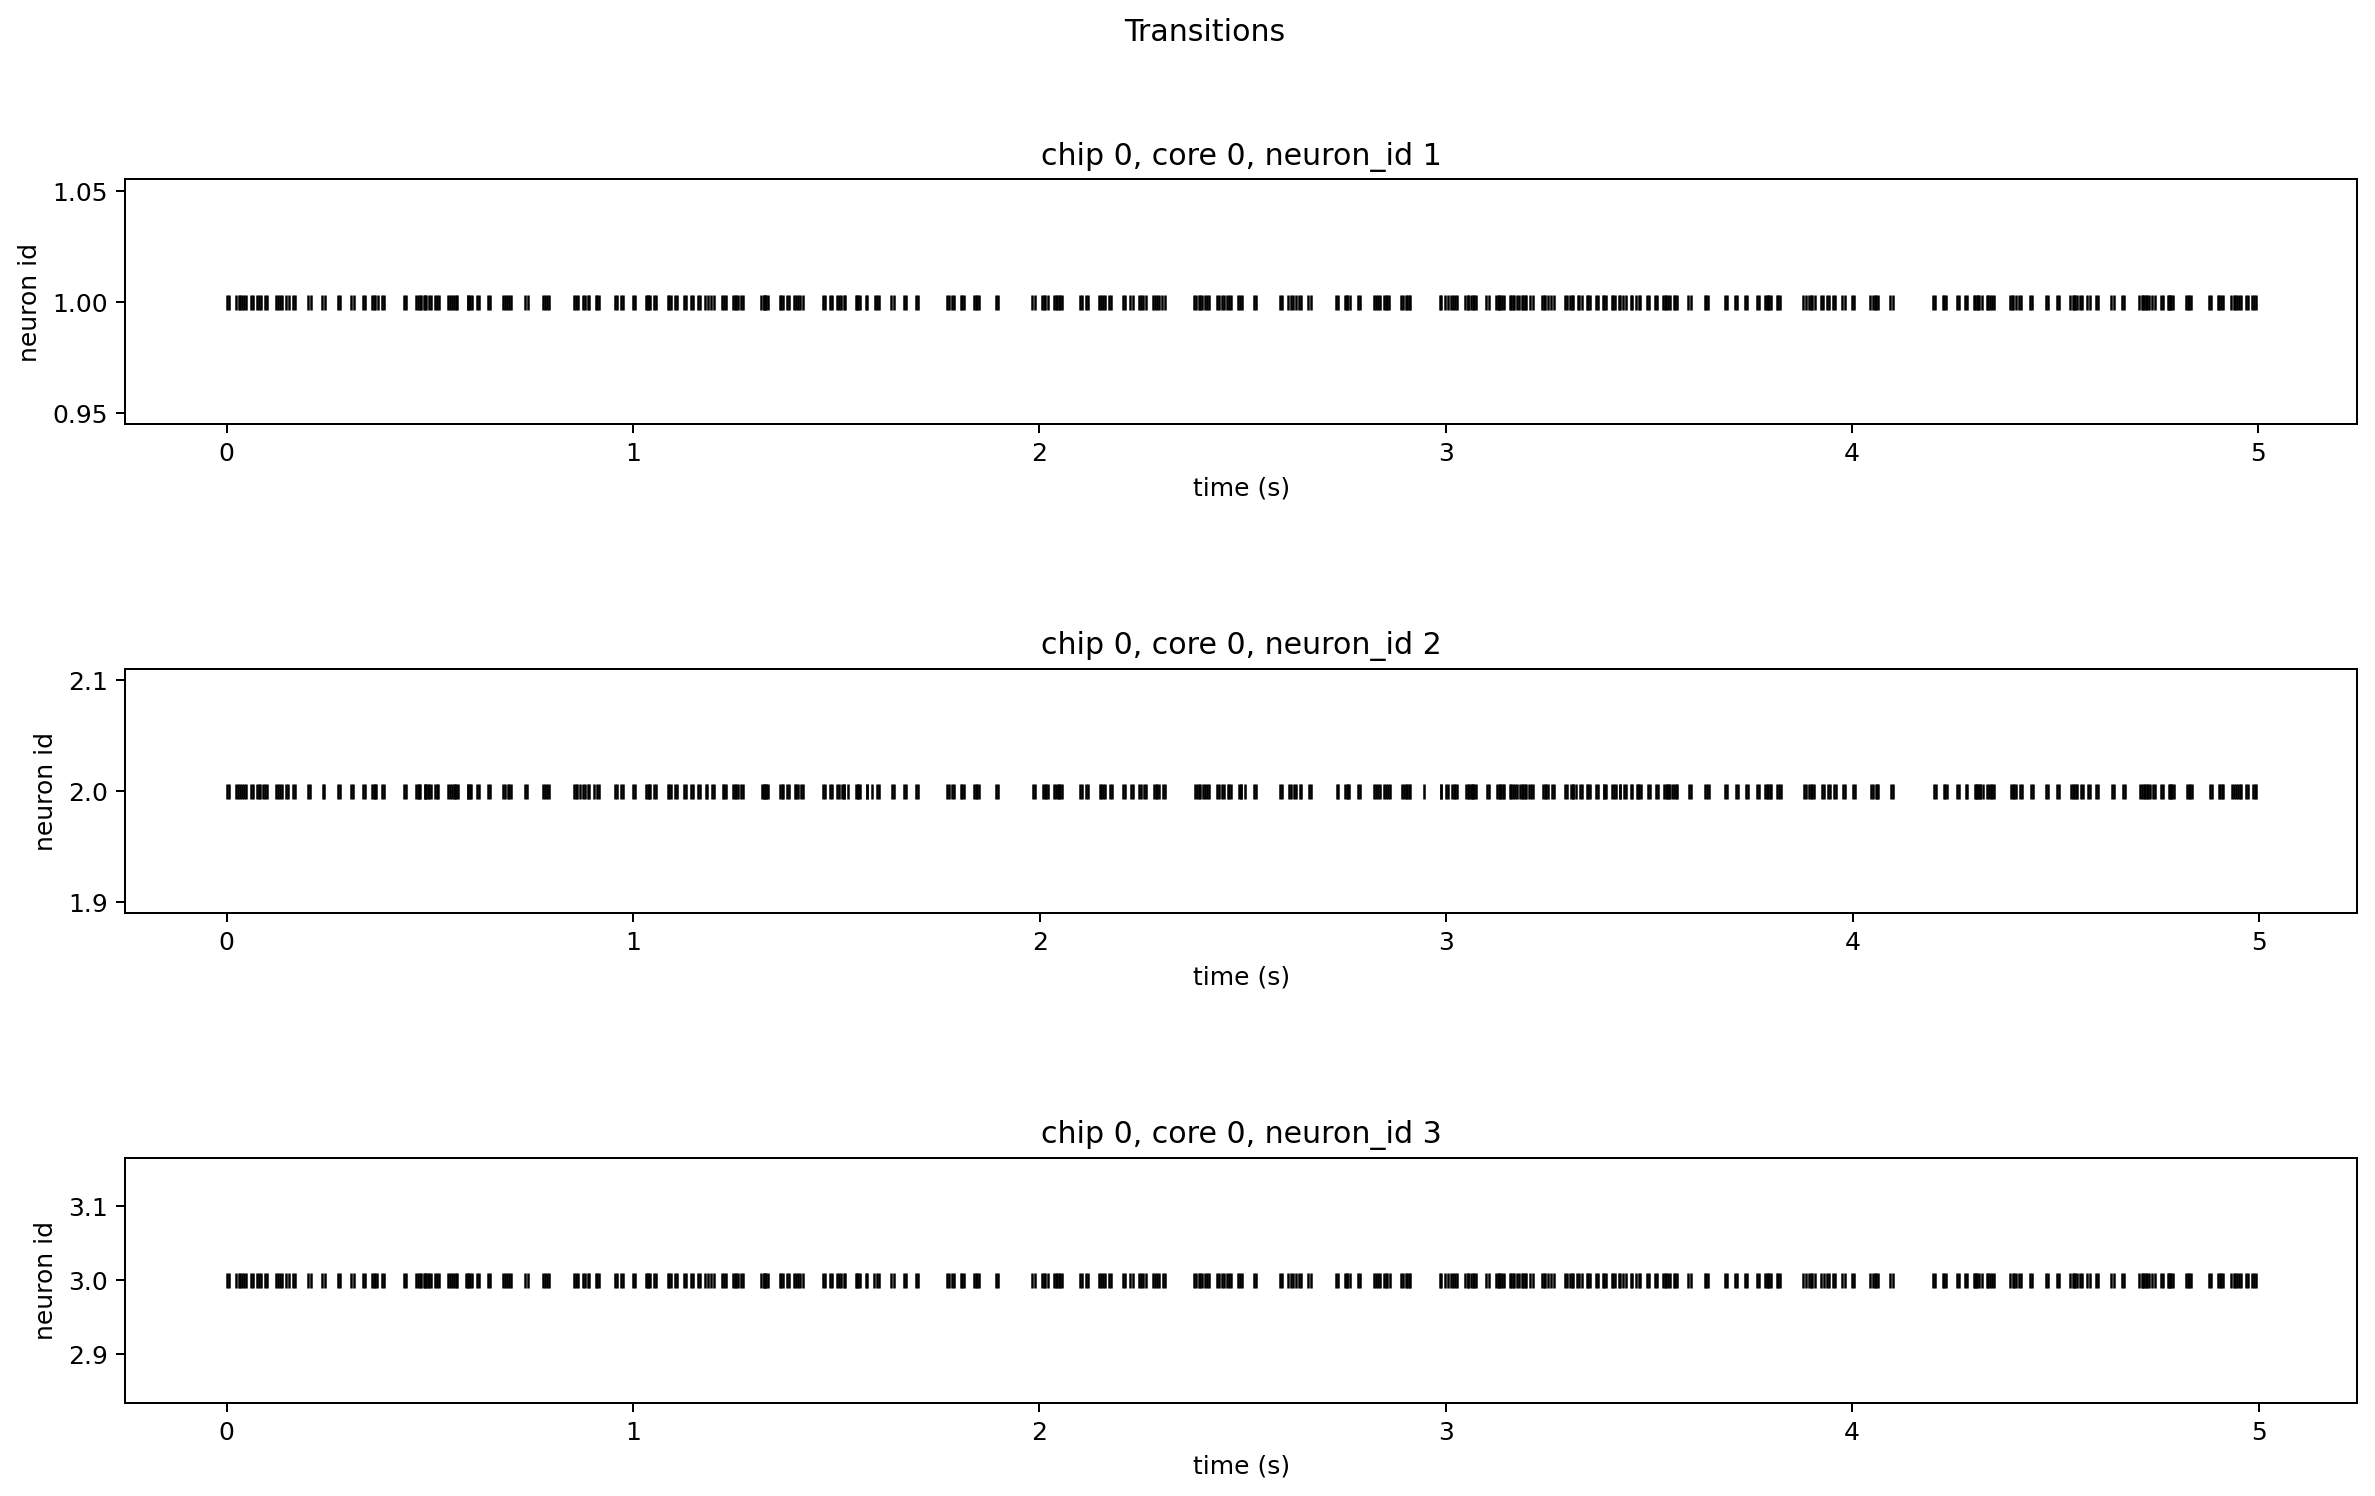

In [112]:
neuron_groups = {'Transitions': monitored_neurons[0:3], 
                         'States': monitored_neurons[3:6], 
                         'Inhibitory 1': monitored_neurons[6:9], 
                         'Inhibitory 2' : monitored_neurons[9:12], 
                         'Sum and WTA': monitored_neurons[12:14]}

if len(df_spikes) > 0:
    plot_all(df_spikes, 'Transitions', neuron_groups['Transitions'])     

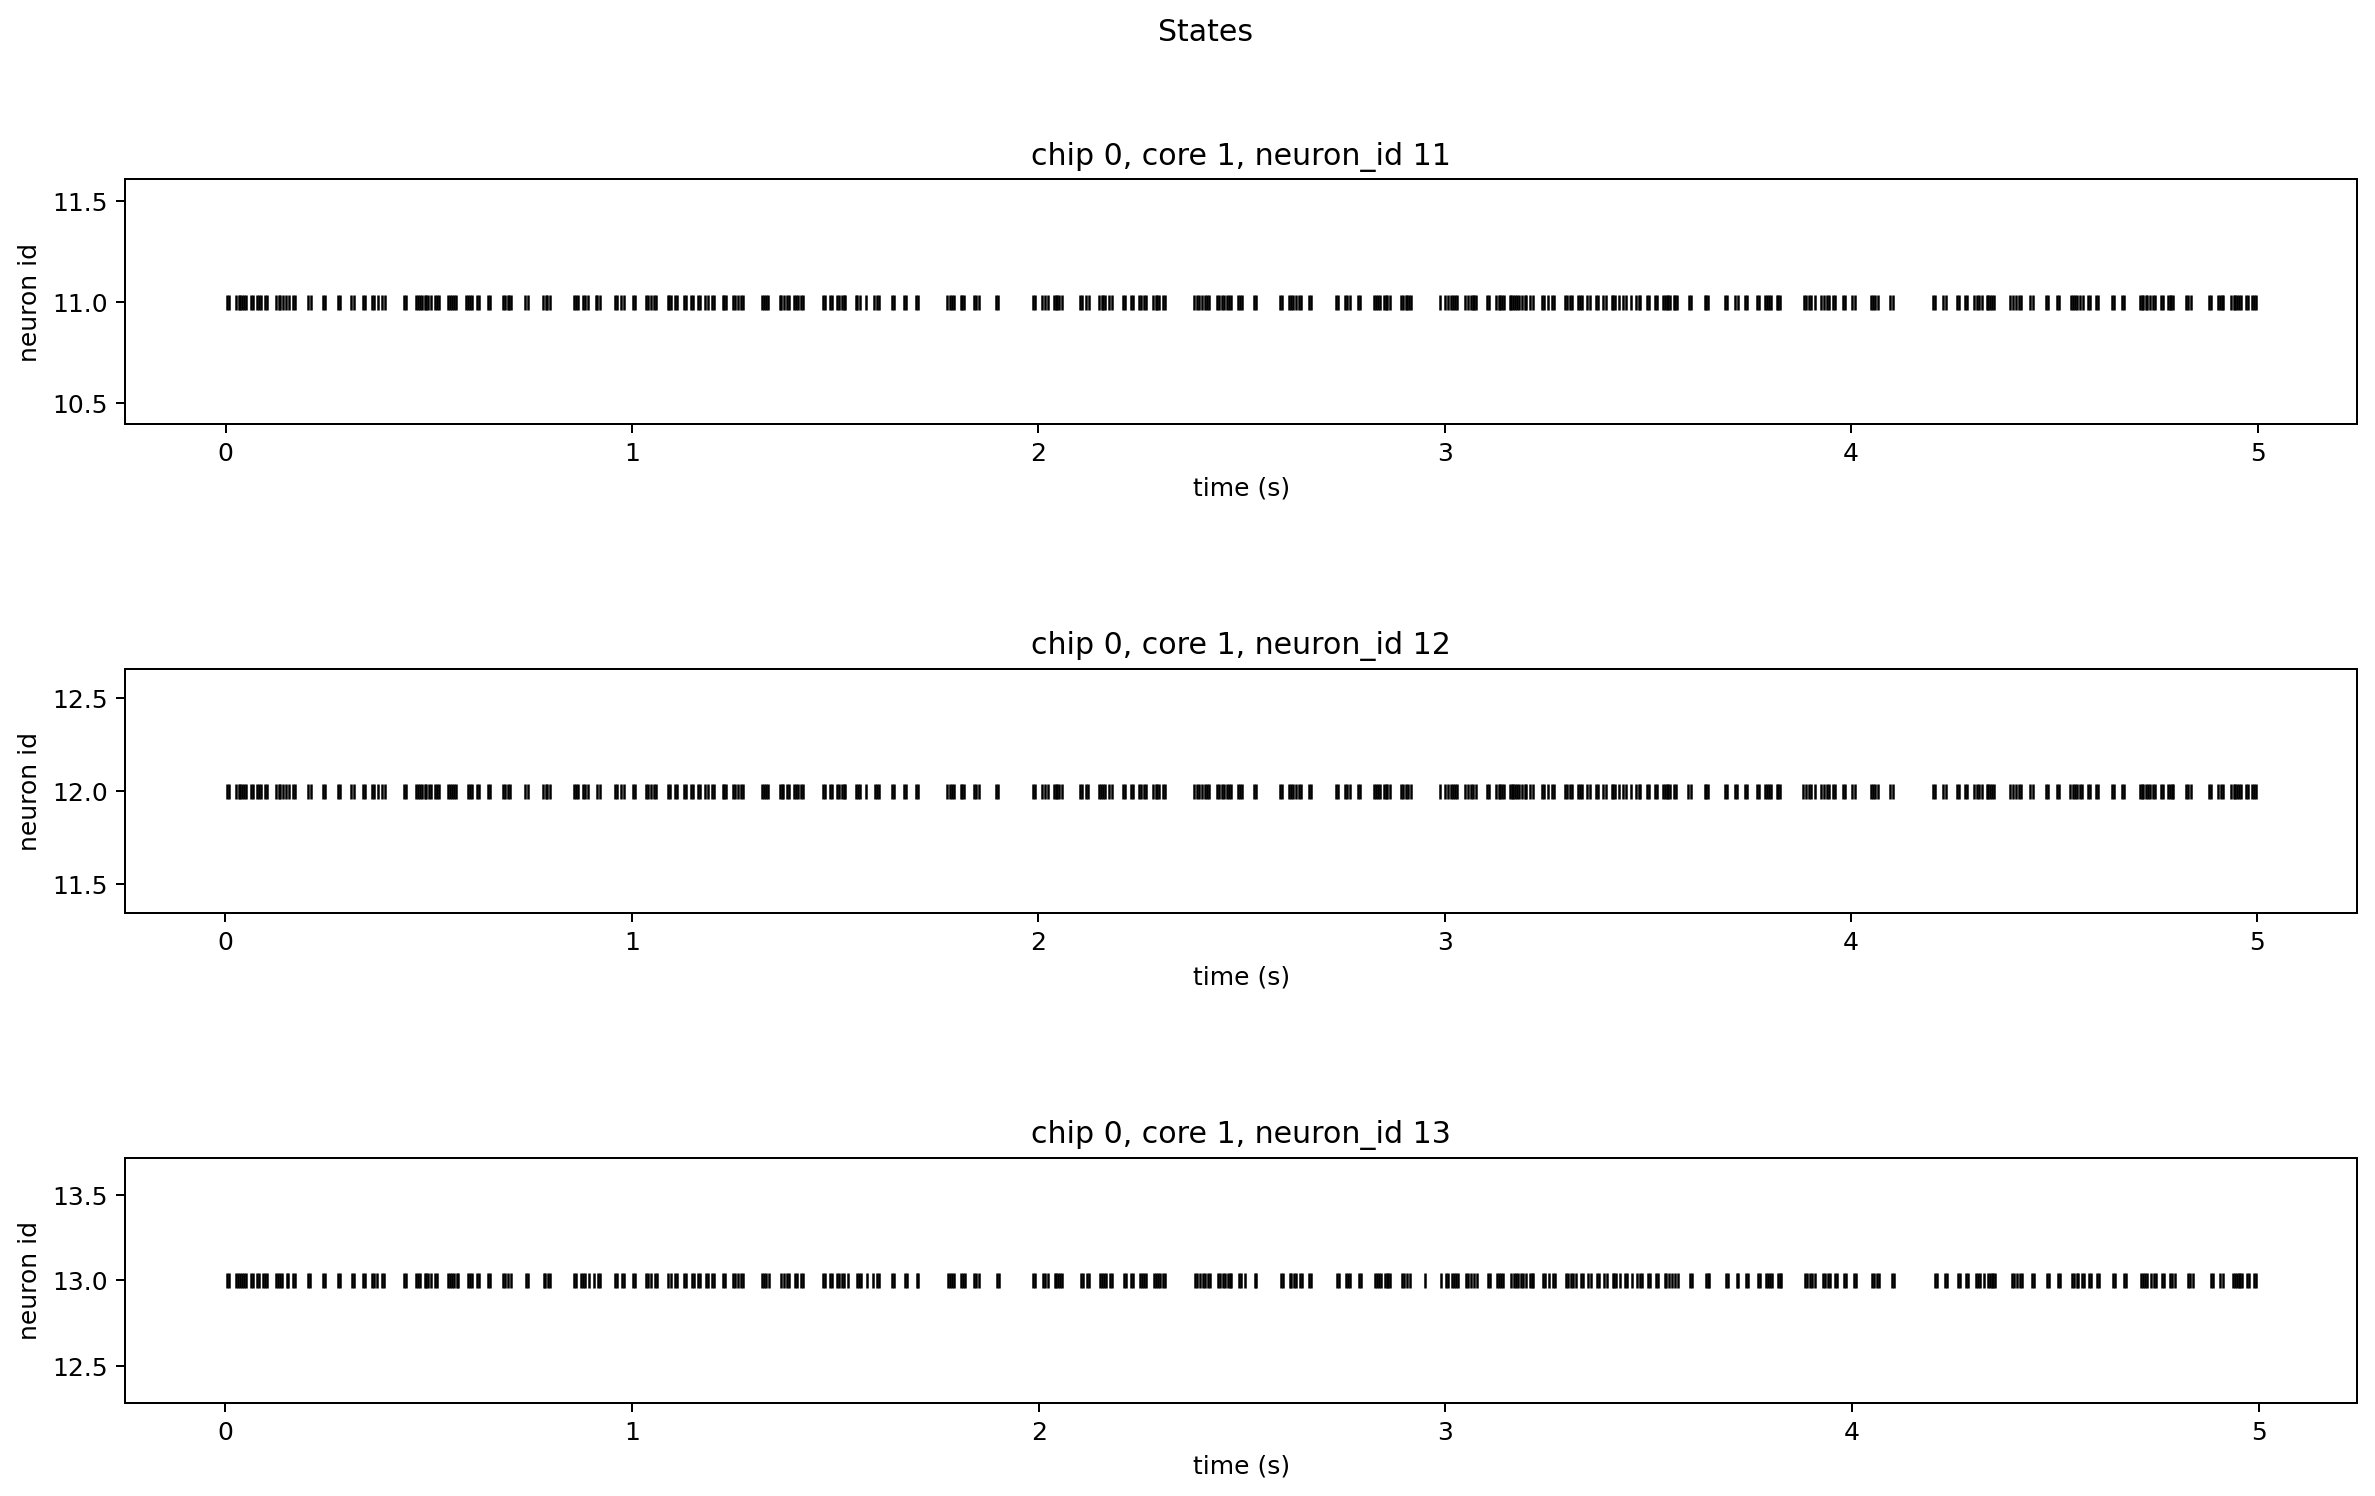

In [113]:
if len(df_spikes) > 0:
    plot_all(df_spikes, 'States', neuron_groups['States']) 

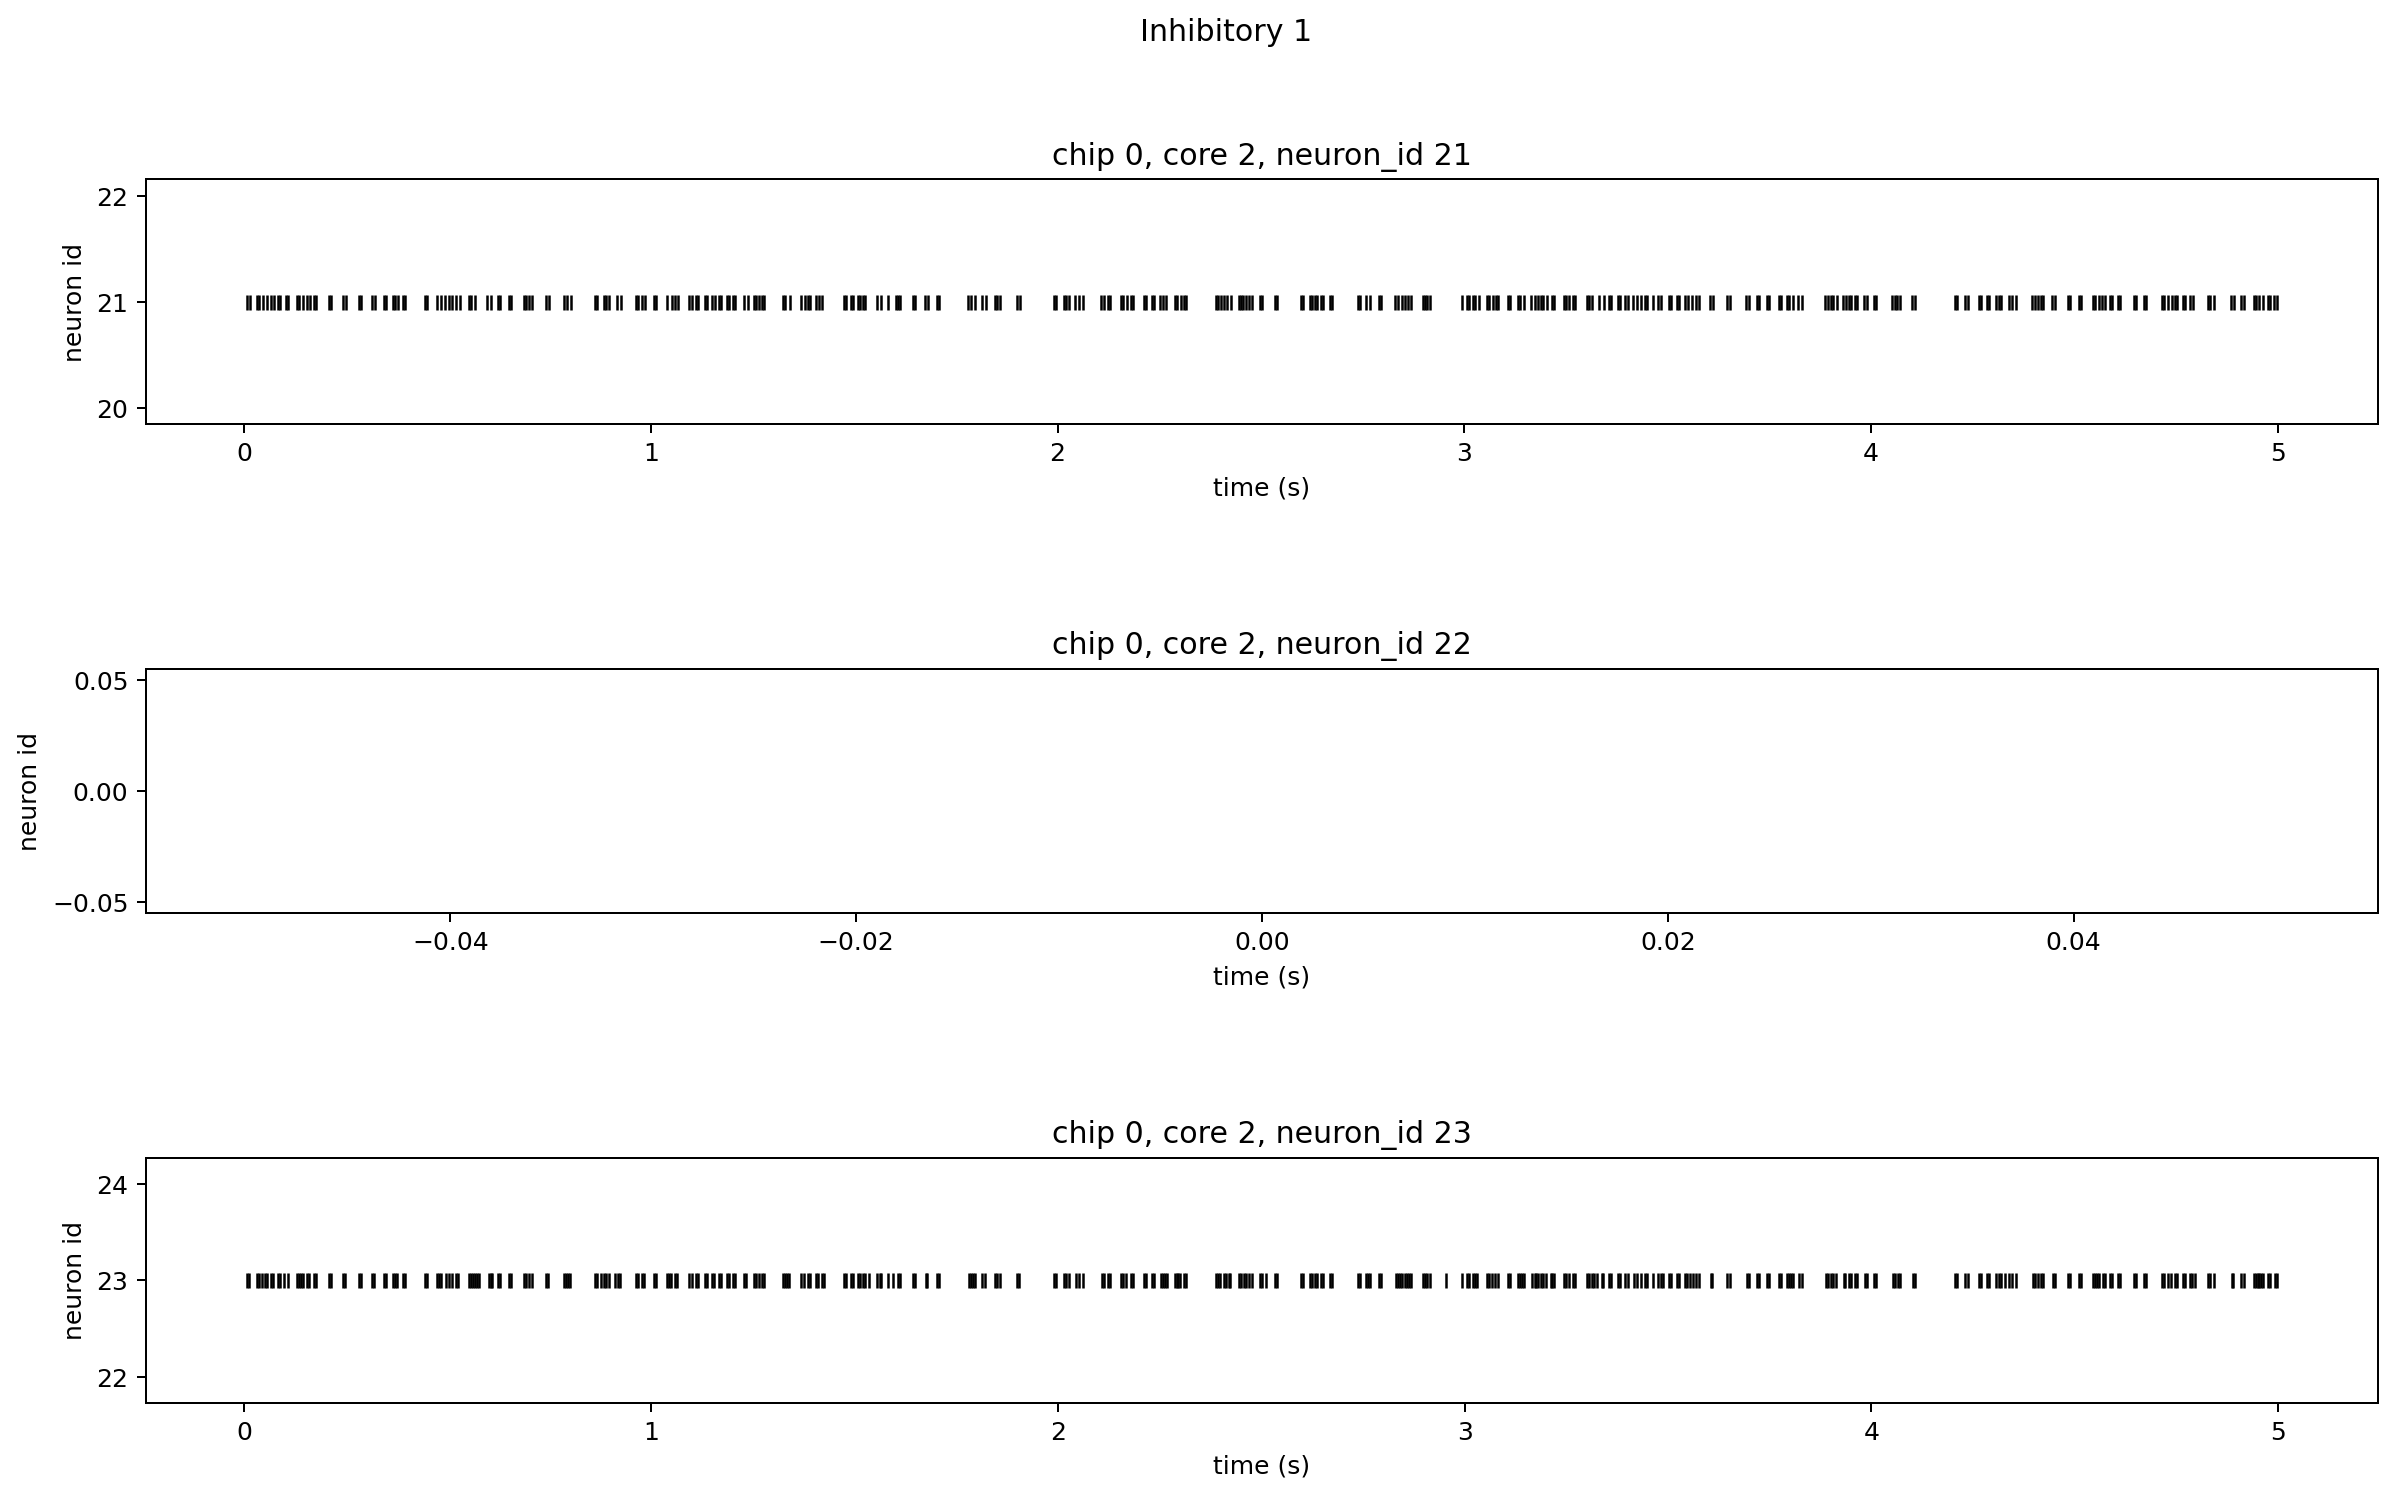

In [114]:
if len(df_spikes) > 0:
    plot_all(df_spikes, 'Inhibitory 1', neuron_groups['Inhibitory 1']) 

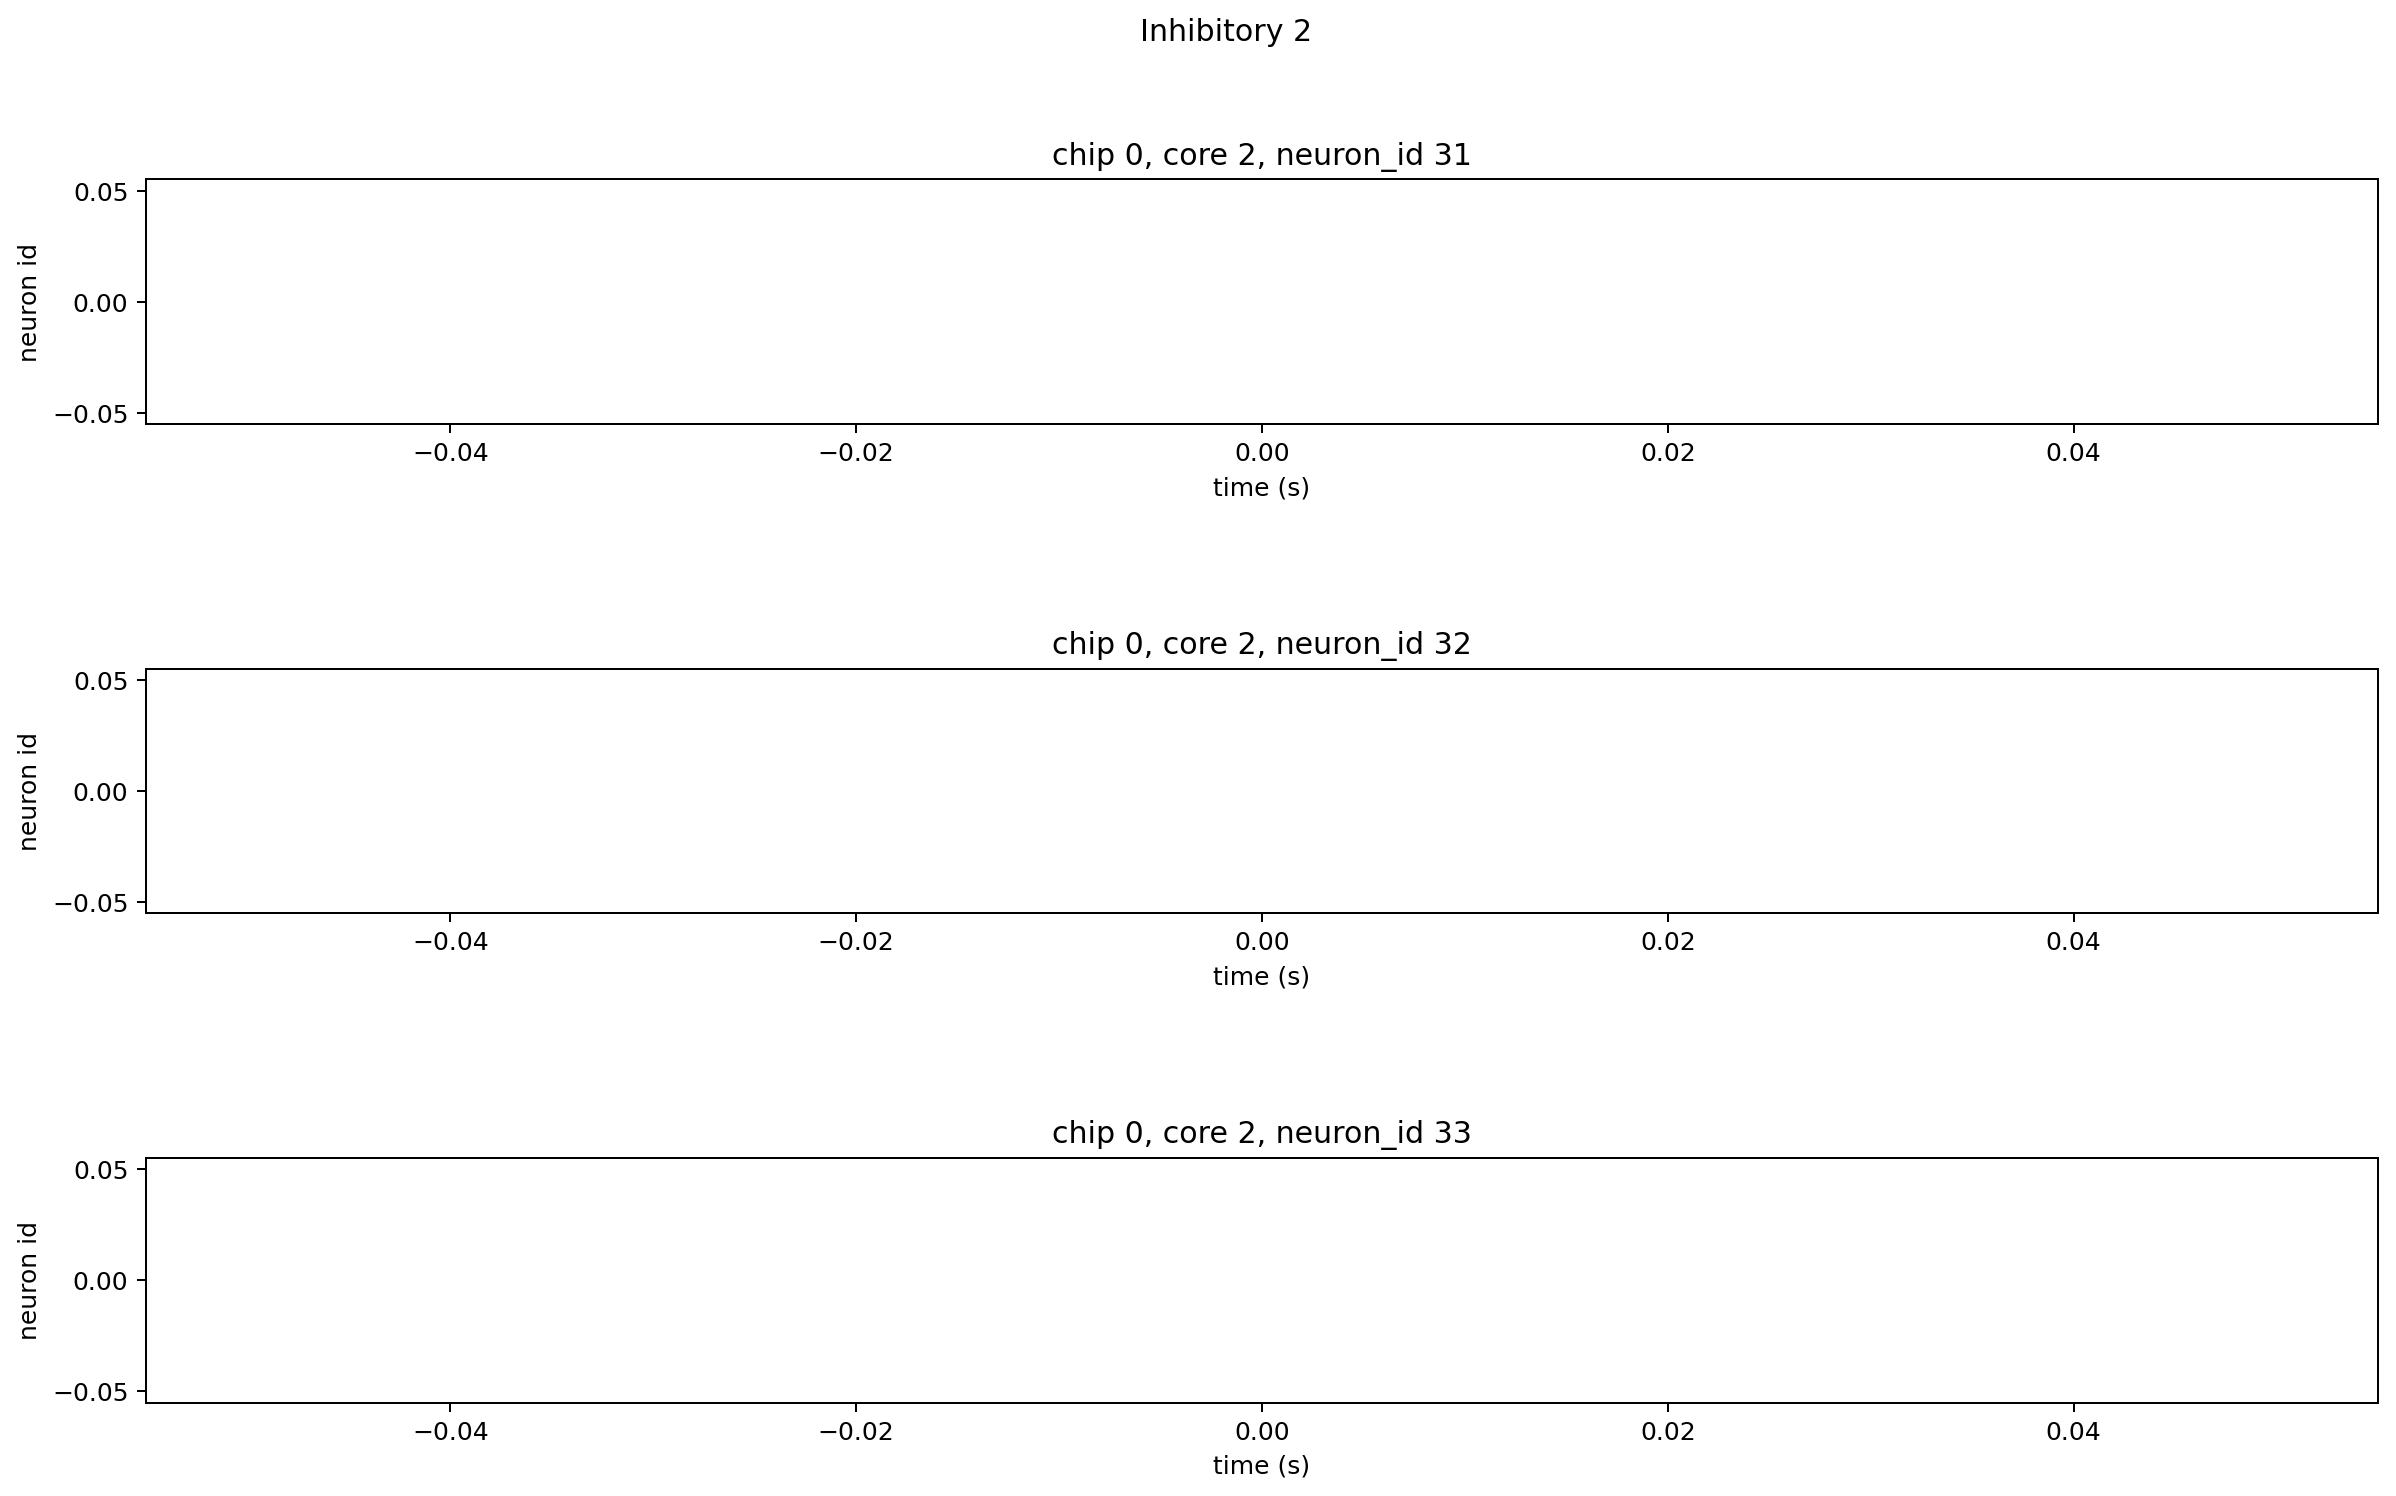

In [115]:
if len(df_spikes) > 0:
    plot_all(df_spikes, 'Inhibitory 2', neuron_groups['Inhibitory 2']) 

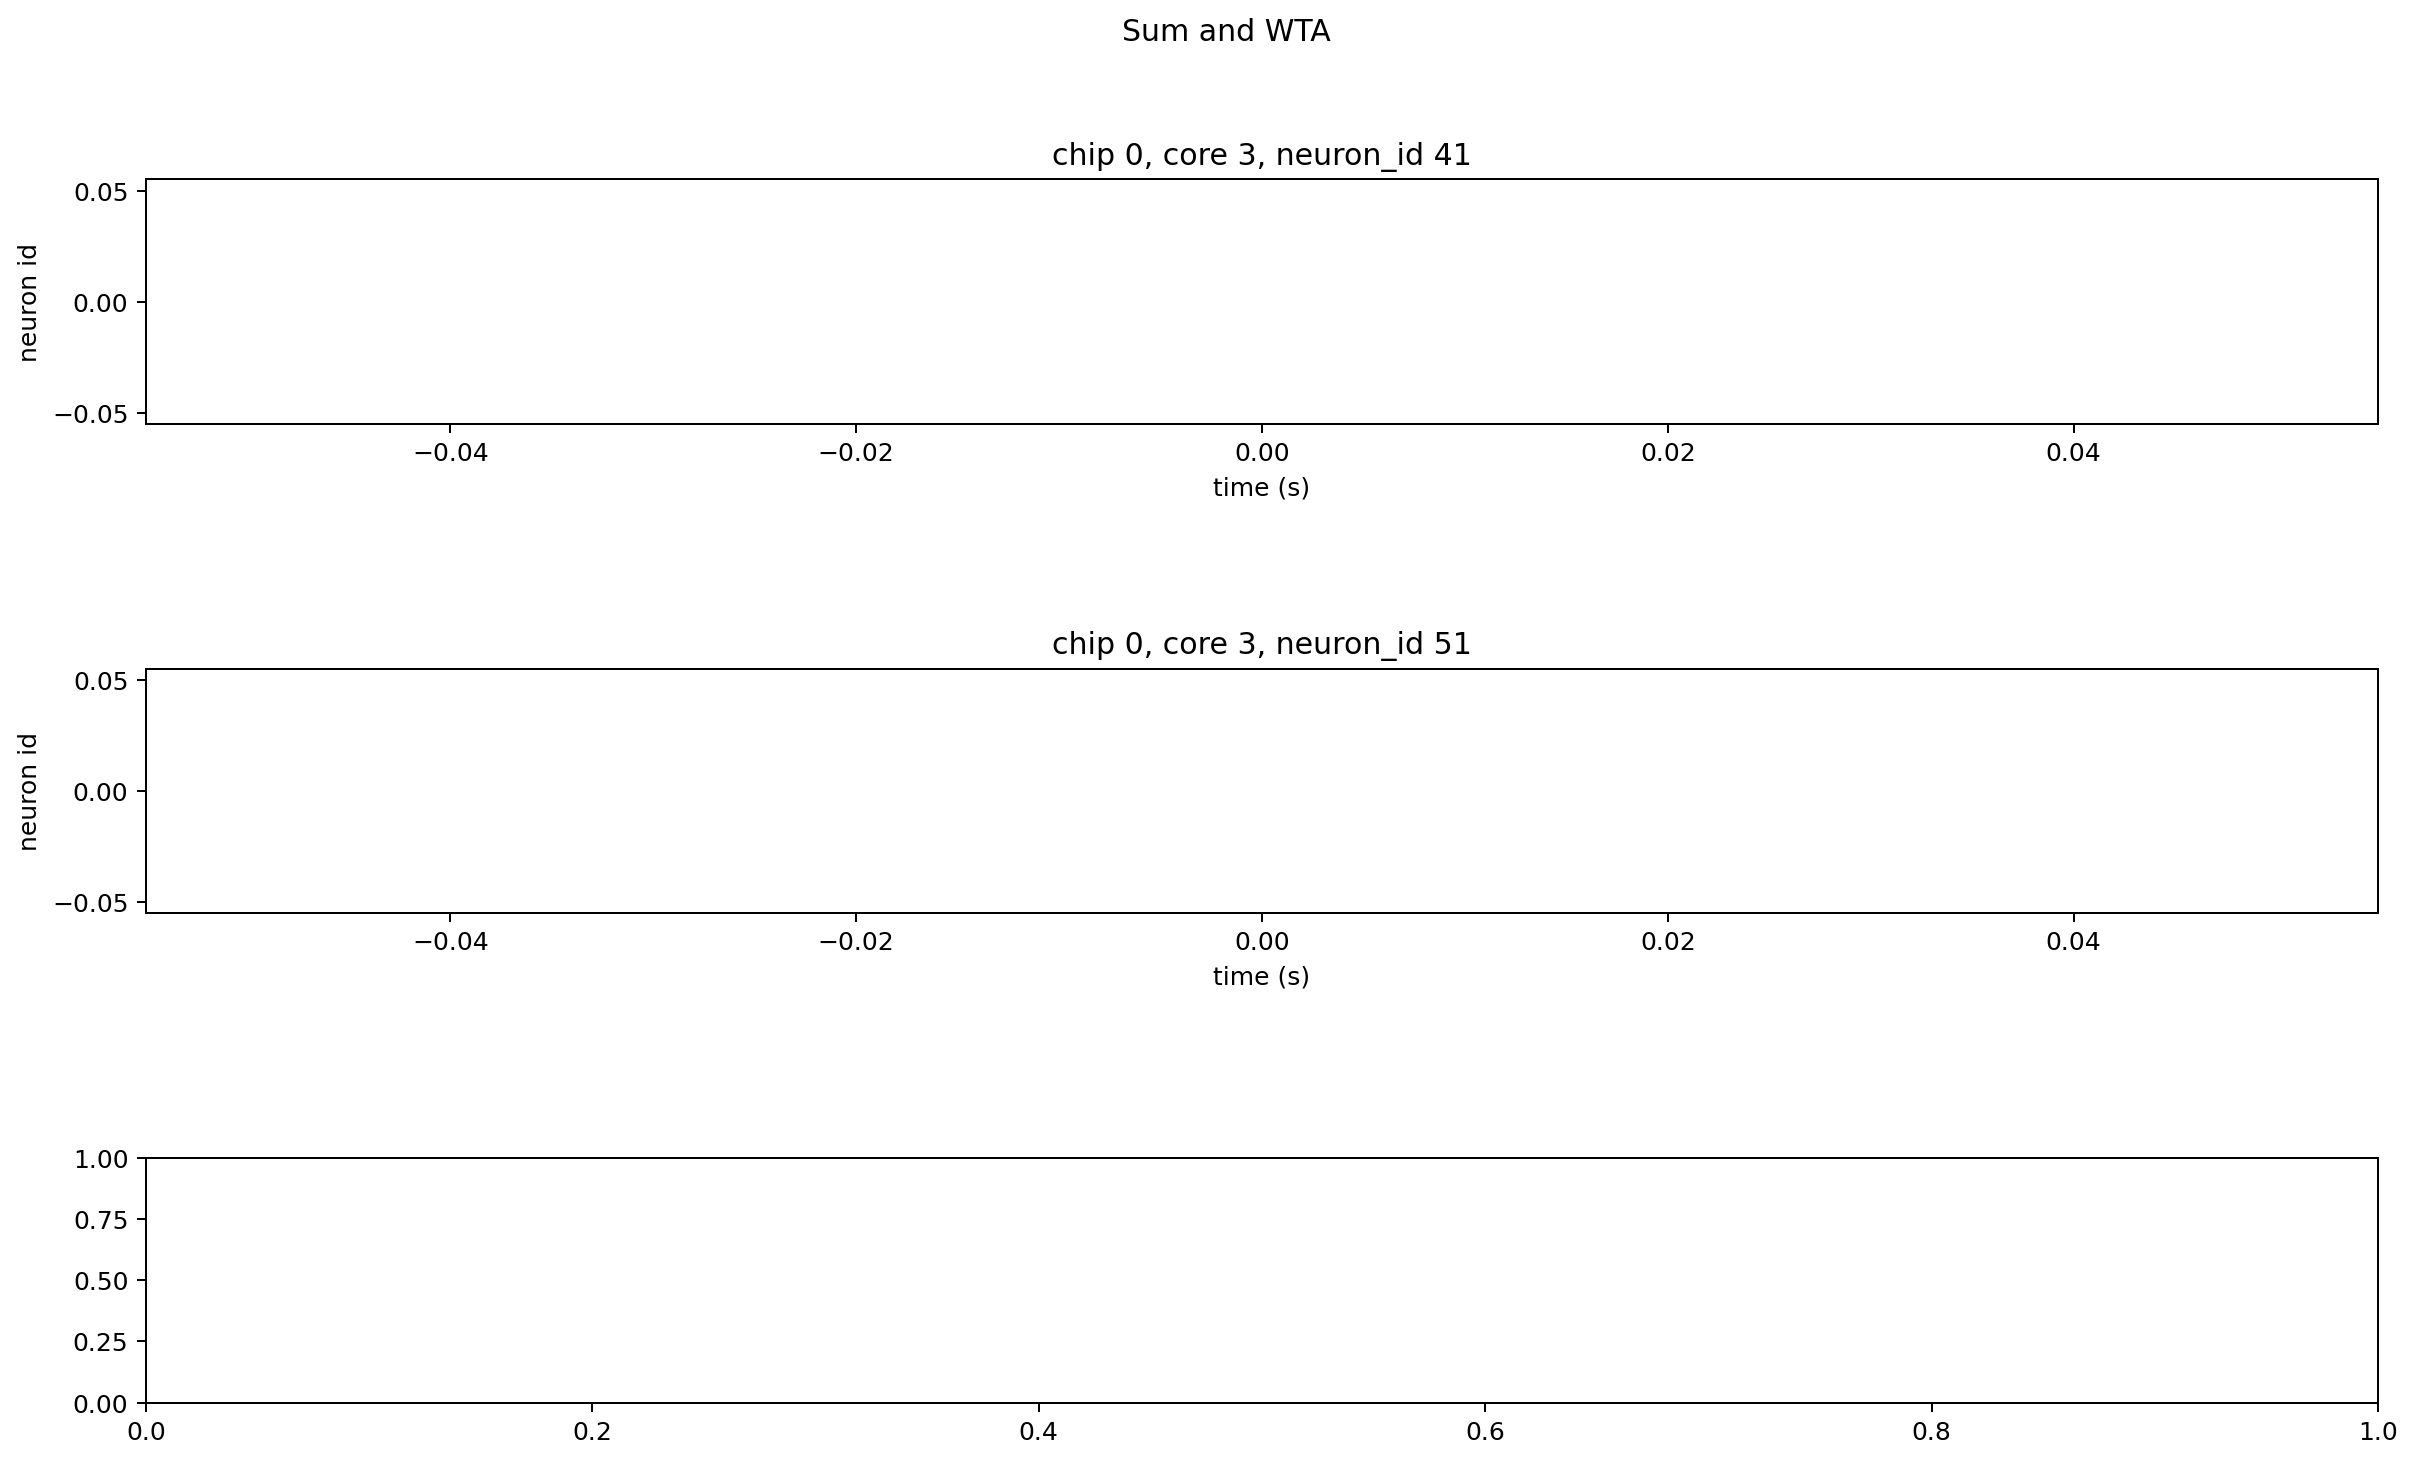

In [116]:
if len(df_spikes) > 0:
    plot_all(df_spikes, 'Sum and WTA', neuron_groups['Sum and WTA']) 